In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import Packages.ClusteringHelper as ch
import numpy as np
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

In [3]:
def ricalcola_lista(lista):
    newlist = []
    for i in reversed(range(1, len(lista))):
        newlist = [lista[i] - lista[i-1]] + newlist
    newlist = [lista[0]] + newlist
    return newlist
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    import re
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]
def get_scores(path):
    from os import listdir
    from os.path import isfile, join
    import re
    mypath = path
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and f != "settings.txt"]
    onlyfiles.sort(key=natural_keys)
    bcubeds = []
    ceafms = []
    for f in onlyfiles:
        with open(join(mypath , f),
                  encoding='utf-8') as t:
            text = t.read()
            match = re.search('bcubed_f1: (\d+.\d+)', text)
            if match:
                bcubeds.append(float(match.group(1)))
            match = re.search('CEAFm: (\d+.\d+)', text)
            if match:
                ceafms.append(float(match.group(1)))
    return bcubeds, ceafms

In [4]:
text, data = ch.read_aida_yago_conll(
    "D:\\Sgmon\\Documents\\Magistrale\\TESI\\ClusteringAndLinking\\aida-yago2-dataset\\AIDA-YAGO2-dataset.tsv")
save = False
if save:
    text_file = open('text.txt', 'w')
    text_file.write(text)
    text_file.close()
data

,documents,tokens,indexes,word_indexes,mentions,entities,wikidatas,numeric_codes,alpha_codes
0,0,EU,"(0, 2)",0,,,,,
1,0,rejects,"(3, 10)",1,,,,,
2,0,German,"(11, 17)",2,German,Germany,http://en.wikipedia.org/wiki/Germany,11867,/m/0345h
3,0,call,"(18, 22)",3,,,,,
4,0,to,"(23, 25)",4,,,,,
...,...,...,...,...,...,...,...,...,...
285584,1392,younger,"(1342, 1349)",265,,,,,
285585,1392,brother,"(1350, 1357)",266,,,,,
285586,1392,",","(1358, 1359)",267,,,,,
285587,1392,Bobby,"(1360, 1365)",268,Bobby,Bobby_Charlton,http://en.wikipedia.org/wiki/Bobby_Charlton,4224,/m/01c8x


In [5]:
ents_data = data[data['entities'] != ''].copy()

In [6]:
from pathlib import Path

path_train = Path(
    "D:\\Sgmon\\Documents\\Magistrale\\TESI\\ClusteringAndLinking\\aida-yago2-dataset\\encodings\\AIDA-YAGO2_train_encodings.jsonl")
path_testa = Path(
    "D:\\Sgmon\\Documents\\Magistrale\\TESI\\ClusteringAndLinking\\aida-yago2-dataset\\encodings\\AIDA-YAGO2_testa_encodings.jsonl")
path_testb = Path(
    "D:\\Sgmon\\Documents\\Magistrale\\TESI\\ClusteringAndLinking\\aida-yago2-dataset\\encodings\\AIDA-YAGO2_testb_encodings.jsonl")
raw_encodings_train = open(path_train, 'r').read()
raw_encodings_testa = open(path_testa, 'r').read()
raw_encodings_testb = open(path_testb, 'r').read()

In [7]:
import json

jsonl_parsed_train = [json.loads(x) for x in raw_encodings_train.splitlines()]
jsonl_parsed_testa = [json.loads(x) for x in raw_encodings_testa.splitlines()]
jsonl_parsed_testb = [json.loads(x) for x in raw_encodings_testb.splitlines()]
jsonl_parsed = jsonl_parsed_train + jsonl_parsed_testa + jsonl_parsed_testb
encodings = [x['encoding'] for x in jsonl_parsed]

In [8]:
entities = list(ents_data.entities)

In [9]:
ents_dict = {ent:[] for ent in entities}
for i, ent in enumerate(entities):
    ents_dict[ent].append(encodings[i])

In [10]:
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm
max_distances = []
for x in tqdm(ents_dict.values()):
    if len(x) > 1:
        max_distances.append(np.max(cdist(x,x, metric='cosine')))

  0%|          | 0/5598 [00:00<?, ?it/s]

In [11]:
# distanza media massima nei cluster
max_distance_mean=np.mean(max_distances)
max_distance_mean

0.03678974213038678

In [12]:
# distanza mediana massima nei cluster
max_distance_median=np.median(max_distances)
max_distance_median

0.029085082846423638

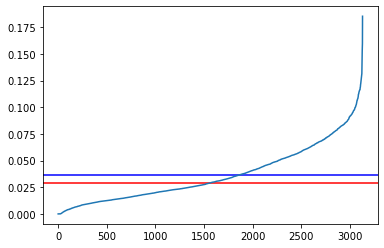

In [13]:
# distribuzione delle distanze massime nei cluster
max_distances.sort()
plt.axhline(y=max_distance_median, color='r', linestyle='-')
plt.axhline(y=max_distance_mean, color='b', linestyle='-')
plt.plot(max_distances)

In [14]:
# varianza dei cluster
var_distances = []
for x in tqdm(ents_dict.values()):
    if len(x) > 1:
        matrix = cdist(x,x, metric='cosine')
        matrix = matrix[~np.eye(matrix.shape[0],dtype=bool)].reshape(matrix.shape[0],-1)

        var_distances.append(np.var(matrix))

  0%|          | 0/5598 [00:00<?, ?it/s]

In [15]:
# media della varianza
np.mean(sorted(var_distances))

0.000135063425200384

In [16]:
# varianza massima
np.max(sorted(var_distances))

0.00261428652061785

In [17]:
#distrubuzione lunghezza cluster
from collections import Counter
from matplotlib.pyplot import figure
lists = sorted(dict(Counter([len(x) for x in ents_dict.values()])).items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
x = [str(el) for el in x]
figure(figsize=(25,5), dpi=1200)
plt.xlabel("Lunghezza del cluster")
plt.ylabel("# elementi")
plt.bar(x, y)
# plt.savefig('./images/prova2.png')

<BarContainer object of 100 artists>

In [18]:
x = [int(el) for el in x]
np.max(x)

636

In [19]:
# media lunghezza cluster > di 2 elementi
np.mean([len(x) for x in ents_dict.values()])

4.969096105752055

In [20]:
# mediana lunghezza cluster > di 2 elementi
np.median([len(x) for x in ents_dict.values()])

2.0

Text(1000, 0.041789742130386776, '0.03679')

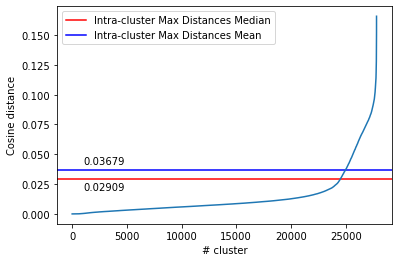

In [21]:
# algoritmo knn con numero di vicini il la lunghezza media di un cluster

neighbors = NearestNeighbors(n_neighbors=5, metric='cosine')
neighbors_fit = neighbors.fit(encodings)
distances, indices = neighbors_fit.kneighbors(encodings)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.axhline(y=max_distance_median, color='r', linestyle='-', label='Intra-cluster Max Distances Median')
plt.axhline(y=max_distance_mean, color='b', linestyle='-', label='Intra-cluster Max Distances Mean')
plt.plot(distances)
plt.xlabel('# cluster')
plt.ylabel('Cosine distance')
plt.legend(loc='upper left')
plt.text(1000, max_distance_median - 0.009, str(round(max_distance_median, 5)))
plt.text(1000, max_distance_mean + 0.005, str(round(max_distance_mean, 5)))

# plt.savefig('./images/max_distance_in_gold.png')

## Tempo di calcolo

In [22]:
step1 = [0, 0.03015932091511786, 0.04376691882498562, 0.058524902909994125, 0.09607938001863658, 0.12044322490692139, 0.16188389994204044, 0.22033005603589118, 0.2705306988209486, 0.34587828791700304, 0.4003494349308312, 0.45978273288346827, 0.5260001190472394, 0.5936439130455256, 0.6862457180395722, 0.8212691689841449, 0.947952349903062, 1.0712711228989065, 1.1918532468844205, 1.3375418088398874, 1.5164868449792266, 1.6987453850451857, 2.0146776819601655, 2.2610564169008285, 2.5635285298340023, 2.887656051898375, 3.19262896804139, 3.4939906438812613, 3.832057412015274, 4.169899974949658, 4.669632914941758, 5.079537887824699, 5.584571976913139, 6.126169173978269, 6.685238305944949, 7.233094550902024, 7.790844674920663, 8.374357818858698, 9.012723510852084, 9.657121069030836, 10.490711549995467, 11.245876541826874, 12.730065010022372, 13.492846588836983, 14.241200377931818, 15.065337899839506, 15.897752102930099, 16.804412774043158, 17.73321299883537, 18.64829718787223, 19.657172617968172, 20.63936984585598, 21.681173336924985, 22.69889977085404, 23.76344705396332, 24.79740502499044, 25.894475186942145, 27.093226292869076, 28.24997998494655, 29.43931405991316, 30.664405421819538, 32.34922229894437, 33.97904076683335, 35.592079726047814, 37.88214090582915, 39.58784841001034, 41.32554763695225, 43.01194295892492, 44.768853877903894, 46.62187805096619, 48.462654494913295, 50.382806985871866, 52.23444763291627, 54.32383405393921, 56.439080925891176, 58.548209549859166, 60.80051078693941, 62.9494352620095, 65.12388786487281, 67.39619668503292, 70.21879644691944, 72.51944336295128, 74.90364297502674, 77.28745334292762, 79.75424704700708, 82.31160447886214, 84.81890393886715, 87.42289551603608, 90.04287570202723, 92.67087088804692, 95.38799536298029, 98.24727519694716, 101.08660412486643, 104.62331777694635, 107.50800439994782, 110.50977509701625, 113.45815879083239, 116.44360476499423, 119.42853492381983, 122.54157045204192, 125.60817054286599, 128.66961222188547, 131.73173139896244, 134.84095168602653, 138.5992937979754, 141.7392485048622, 144.90248836600222, 148.015772475861, 151.1972365048714, 154.46280911983922, 157.7312184588518, 161.0181667858269, 164.35402875300497, 167.68317202292383, 171.067817869829, 175.0642198070418, 178.7169752488844, 182.30053829890676, 186.13823127304204, 190.89973504003137, 195.25791443302296, 200.09698574896902, 204.88371225097217, 209.7723962229211, 215.25642818096094, 220.02855152403936, 224.87959086685441, 229.86105454689823, 234.7847636619117, 239.75869811396115, 244.76703575090505, 249.80913533782586, 254.79832850699313, 260.65685201692395, 265.7970537750516, 272.3496985780075, 278.4473397969268, 284.47603144194, 290.5150868089404, 296.65369502385147, 302.8715864450205, 309.7295588068664, 315.9496130058542, 322.19185816985555, 328.43569473782554, 334.8042140859179, 341.1573006538674, 347.59015559684485, 354.02302275202237, 361.0199111979455, 367.39633699902333, 373.8684706899803, 380.3028349438682, 386.83262787689455, 393.68310928088613, 400.49815219291486, 408.1736095738597, 415.47521587694064, 422.56634310190566, 429.96900927182287, 437.26292557804845, 444.7556957239285, 452.05858114594594, 460.14996989793144, 467.4796857780311, 475.0540741470177, 482.57259812392294, 490.00819149496965, 497.7381977350451, 505.5797333070077, 513.9718519588932, 521.8436087940354, 530.1577627309598, 538.2552091348916, 546.3217004518956, 554.4679630708415, 562.4828600708861, 571.1449565070216, 579.3887146220077, 587.7438389388844, 596.1381364369299, 604.5385186600033, 612.8882185728289, 621.924595184857, 630.4586838069372, 638.9804621250369, 647.6229601469822, 656.5581920340192, 665.0520751189906, 674.4278264709283, 682.923599494854, 691.6232559808996, 700.5133276798297, 709.3644389868714, 718.0800028720405, 726.7864182828926, 736.0467929048464, 744.7517082788981, 753.4960397819523, 762.6028153889347, 771.6519006828312, 780.6576438178308, 790.2037837719545, 799.6326813919004, 808.8247123919427, 818.1758509308565, 827.7139882668853, 837.2330599108245, 847.2713657219429, 856.7103120419197, 866.306960253045, 876.2172853229567, 885.9706992360298, 896.0474397230428, 906.4051962059457, 916.483591707889, 926.3857966298237, 936.6652113830205, 946.5288053888362, 956.5309950099327, 967.1020765048452, 977.3396843478549, 987.5037894540001, 997.6991121219471, 1008.1256700209342, 1018.4384449059144, 1029.3040304819588, 1040.0483677028678, 1050.686505189864, 1061.5174047858454, 1072.805633208016, 1084.3771402109414, 1095.412285642, 1106.6573622408323, 1117.7426729809958, 1129.1404238089453, 1140.4078414118849, 1152.3453097778838, 1163.6476204819046, 1175.0439941198565, 1186.5100368019193, 1198.5327373209875, 1210.960114430869, 1222.9047990008257, 1234.6440341840498, 1247.1350116149988, 1259.2607497340068, 1272.2240584688261, 1284.7323581359815, 1297.3977376269177, 1309.7901271139272, 1322.7907519538421, 1335.3064242040273, 1348.4338922200259, 1360.6090509819333, 1373.0660503320396, 1385.7290249539074, 1398.3704353750218, 1411.6197338919155, 1424.0558462168556, 1436.6275860958267, 1449.322599495994, 1462.1557291578501, 1475.965847325977, 1488.8175862259232, 1501.889859431889, 1514.9697491070256, 1527.9094129388686, 1541.4481272189878, 1554.4134051399305, 1567.6127313198522, 1581.221642816905, 1594.5121648188215, 1608.288984984858, 1621.9768872580025, 1635.498028955888, 1648.96402596985, 1662.6021412259433, 1676.6384400930256, 1690.3751530859154, 1703.8479393608868, 1717.8166845280211, 1731.504844933981, 1746.2964315018617, 1760.550917493878, 1774.7473949699197, 1788.986987276934, 1803.1960585960187, 1817.902831468964, 1832.215270896908, 1846.6135037930217, 1861.427138685016, 1876.8683258360252, 1891.7194515250158, 1906.8175076218322, 1921.7731564480346, 1936.7291746609844, 1952.5499525568448, 1967.7904305958655, 1983.195448274957, 1998.3875819188543, 2013.7881081318483, 2029.78042670805, 2045.0077670859173, 2060.3058842699975, 2076.1079219100066, 2091.9993903038558, 2107.6744094998576, 2123.307371265022, 2138.9517161760014, 2154.485716250958, 2170.6821866498794, 2186.859552414855, 2203.4752990328707, 2219.809708965011, 2236.7208113218658, 2253.133652180899, 2269.4201092149597, 2285.6778764128685, 2304.7745176998433, 2323.419386146823, 2341.3299980559386, 2358.9609644149896, 2376.726127136033, 2395.1665043910034, 2413.3233740078285, 2431.5100644750055, 2449.607756310841, 2468.152886247961, 2486.413950864924, 2504.3028197488748, 2522.6772232698277, 2541.068860276835, 2561.1273399100173, 2580.701103182044, 2600.239330264041, 2619.5136990030296, 2639.8404663549736, 2659.346331629902, 2678.875998263946, 2698.8716866818722, 2719.0397143990267, 2738.2823602028657, 2758.02643105085, 2777.6148778479546, 2798.0264149939176, 2818.3119673558977, 2838.1629970339127, 2858.191066237865, 2881.103697872022, 2901.3891543289647, 2923.3413499218877, 2944.813420107821, 2966.778407038888, 2987.802841539029, 3009.7364603260066, 3031.4558485909365, 3053.7668962648604, 3075.5022287450265, 3097.9068199228495, 3120.0060171009973, 3143.170984862838, 3164.701845966978, 3186.4931706099305, 3209.1895703189075, 3231.592313248897, 3253.1531540078577, 3275.160923613934, 3297.0115751929116, 3319.360825113021, 3341.445495582884, 3363.395419501001, 3385.458965486847, 3407.867282378953, 3429.9529727019835, 3452.2398507560138, 3475.4528856649995, 3497.6169051199686, 3519.7471285290085, 3543.382749177981, 3566.283749470953, 3588.9222772528883, 3612.092599926982, 3635.2370812408626, 3658.669015704887, 3681.712795845, 3704.8028969608713, 3728.605370696867, 3751.839816587977, 3774.8252095489297, 3797.9240196458995, 3821.949676119024, 3844.9118397259153, 3868.0552685409784, 3891.5435173648875, 3915.68018302205, 3938.857009322848, 3962.311436783988, 3986.3414786129724, 4009.7554702940397, 4033.6084719349165, 4057.7624767008238, 4082.843899163883, 4108.961329459911, 4133.395309119951, 4158.169104456902, 4184.132048124913, 4208.205516374903, 4232.316629854962, 4258.23740841588, 4282.608219661051, 4307.030950858956, 4333.0483668509405, 4358.691865117988, 4383.873375536874, 4408.760432873853, 4434.470942387823, 4460.476956022903, 4485.48275969387, 4511.076263969997, 4539.071859693853, 4564.404695041943, 4589.361576823983, 4614.872050849022, 4640.710981255863, 4666.2005583930295, 4691.467037214898, 4718.689118131995, 4744.0375488640275, 4769.740212896839, 4795.4572118248325, 4822.625470867846, 4848.593802436022, 4874.736925001955, 4903.032791555859, 4930.676820840919, 4958.835368043045, 4988.179030091036, 5016.095290021971, 5043.987125506857, 5072.464058573823, 5101.46400276199, 5129.3176317999605, 5158.211176806828, 5187.95281862095, 5216.898517390015, 5244.968620467931, 5273.31018135394, 5301.566875357879, 5329.750402987935, 5357.5962629830465, 5386.168897585012, 5414.230524466839, 5442.369881192921, 5470.604792885017, 5498.936351262964, 5526.927376877051, 5555.635938673047, 5584.258046330884, 5612.978699384024, 5641.31980546983, 5670.757626605919, 5699.176270351047, 5727.888336577918, 5756.995340345893, 5785.891343365889, 5814.852365230909, 5844.389498364879, 5873.04710797593, 5902.487143647857, 5931.756728528999, 5961.5441502130125, 5990.304739475017, 6019.352399784839, 6048.731896841899, 6078.181727404008, 6107.710081869969, 6138.634278228972, 6169.608994633891, 6200.4799284278415, 6231.533884325996, 6262.813603527844, 6293.295587092871, 6324.165661087027, 6355.956191155827, 6386.6220071769785, 6417.841842327034, 6449.61769938888, 6480.803610687843, 6511.829874875024, 6543.678368174005, 6574.853506932035, 6606.242035600822, 6638.0118725190405, 6669.256060746964, 6700.620054984, 6732.7671270780265, 6764.0706043508835, 6796.104917181889, 6827.578116512857, 6860.458516706014, 6892.631269539939, 6924.485447551822, 6957.073116427986, 6989.590067669982, 7021.495511441957, 7054.080729550915, 7085.792331225937, 7118.680231252918, 7151.518676951993, 7184.274761473993, 7216.375791221857, 7249.942226661835, 7281.985209294828, 7314.749093631981, 7346.931707181968, 7381.5719458670355, 7415.3048318489455, 7450.054278915981, 7484.04228960094, 7519.637956193881, 7553.141674743965, 7588.154078928987, 7621.724811471999, 7656.86611309601, 7691.466201768955, 7726.459629343823, 7760.427859185031, 7796.760210382985, 7831.360636719968, 7867.455196175957, 7902.482749752002, 7939.06173351896, 7973.824137688847, 8010.560025549028, 8046.052011464955, 8083.279783587903, 8118.748185580829, 8155.3033914710395, 8190.907330136048, 8228.06020503887, 8263.64800905087, 8300.338320011972, 8336.673635097919, 8373.448613847839, 8409.322306365939, 8446.678126772866, 8482.034977694973, 8519.009502641857, 8555.480372696882, 8593.044676194899, 8628.954541384941, 8666.743708255002, 8702.795355934883, 8740.619650173932, 8777.22192518902, 8814.481927052839, 8850.448241624981, 8887.397869723849, 8921.91020200192, 8957.745277023874, 8993.24196890695, 9029.715543512022, 9064.926234134007, 9101.750552848913, 9136.971246705856, 9173.20037595299, 9208.943876873935, 9245.39033760503, 9282.592515819008, 9320.371128809871, 9357.392228282988, 9395.566145930905, 9432.606687146006, 9470.570206224918, 9508.658439995022, 9548.170707580866, 9586.475640092976, 9627.134813538985, 9665.873832962941, 9706.07996493904, 9746.080351986922, 9786.119005230023, 9825.165308502968, 9865.813415579032, 9904.200752850855, 9944.479389322922, 9984.688120655017, 10024.744080822915, 10064.21885908884, 10105.477500712965, 10144.975791238016, 10185.897139800945, 10226.218002269976, 10267.156162610976, 10307.023324631853, 10347.88719333103, 10388.10937146889, 10429.92888562684, 10470.101189974928, 10511.046372286975, 10551.807921180967, 10593.533176570898, 10634.949329596013, 10676.928501475835, 10717.87522365502, 10760.0307729349, 10801.524145700969, 10843.516311927, 10884.225189264864, 10925.832044487819, 10966.39921453991, 11008.617418437032, 11049.380010393914, 11092.91673719883, 11134.037812698865, 11176.006511893822, 11217.369124118937, 11261.094994439045, 11303.21015541302, 11347.136305084918, 11389.36289699399, 11434.451655157842, 11476.440376449842, 11518.645194779849, 11560.806730768876, 11604.053297135048, 11645.59485006705, 11688.784974582959, 11730.636904006824, 11774.264057758031, 11816.573174163, 11859.593016027007, 11902.092871011933, 11945.620625689859, 11987.976210898021, 12032.059049424948, 12074.2395273929, 12117.83825315698, 12160.530480434885, 12203.674623901956, 12246.311979825841, 12290.688910515979, 12332.796016642824, 12376.407938653836, 12418.503688363824, 12463.92993879388, 12508.861853647046, 12554.31112650386, 12599.12937850086, 12645.753424001858, 12690.466166279977, 12736.469281097874, 12780.989658431849, 12827.945094921859, 12873.201528324047, 12919.174048644025, 12964.61952038994, 13011.341789708938, 13057.646855484927, 13104.075975874905, 13149.74752010894, 13197.951257418841, 13242.870485438965, 13292.328194731846, 13341.553898273967, 13391.063159801997, 13439.332134997007, 13487.040235193912, 13533.772928685881, 13583.523651809897, 13630.756473868852, 13680.906038534828, 13728.705264872871, 13778.963685219875, 13827.655252015917, 13876.019352984848, 13923.592031518929, 13974.12967864587, 14021.526415989036, 14070.847478135955, 14118.282115096925, 14166.979697783943, 14215.867133091902, 14264.645243790932, 14312.547027423047, 14361.968368161004, 14409.43254483887, 14458.437419971917, 14505.728211755864, 14556.06208748091, 14603.996653815033, 14652.839131980902, 14701.519196795998, 14751.822454470908, 14800.56604382582, 14849.551618986996, 14897.892272671917, 14949.002450295957, 14997.64309953805, 15047.70214126003, 15096.138940033969, 15146.87727294187, 15195.965482492, 15246.593483612873, 15297.11722160899, 15348.743298122892, 15398.862677528989, 15449.266075931024, 15498.371465043863, 15550.333670957014, 15600.69164478383, 15653.890912592877, 15704.664812655887, 15758.323111995822, 15809.539945299039, 15861.444280499825, 15912.91128954105, 15966.609489032999, 16017.674296851037, 16071.125211736886, 16122.972686186898, 16177.67549381801, 16228.904254668858, 16282.432923577027, 16335.54008350987, 16390.21515854285, 16443.126077265013, 16496.96374911396, 16549.924736195942, 16604.42297439184, 16656.958443474956, 16710.85682372586, 16763.128028500825, 16818.717319895048, 16870.803303920897, 16925.365412864834, 16977.6962958409, 17033.81673375098, 17086.91927601793, 17141.533289517043, 17195.550555201946, 17251.88111594296, 17306.466351894895, 17361.954050333938, 17415.406055734027, 17472.154844970908, 17526.058319729986, 17582.754150541965, 17637.45357564604, 17695.301931248046, 17749.68067723792, 17804.960055605043, 17859.217004007893, 17915.678519077832, 17970.60507570696, 18025.806587592, 18080.046476698946, 18137.63280136697, 18192.385108576855, 18248.56123639294, 18303.416224965826, 18363.255502834916, 18418.153054642025, 18475.775261817034, 18531.329931849847, 18590.675880867988, 18646.608728752006, 18704.21880722791, 18760.16322797304, 18819.577753941994, 18875.463354117004, 18933.078044930007, 18988.432127029868, 19048.402788285865, 19103.97821502993, 19162.69330198085, 19218.624274034984, 19278.79802995082, 19334.756291494938, 19392.898924921872, 19449.356675239047, 19508.987073835917, 19565.802119274857, 19624.31137049105, 19681.010424545035, 19741.040053427918, 19797.15128541598, 19856.458388310857, 19912.624334248016, 19973.134518679, 20029.717334826943, 20089.540092461975, 20146.077701058937, 20207.341703210957, 20263.902796654962, 20324.35349219595, 20381.977848125855, 20442.496725820005, 20500.166282659862, 20560.185810494935, 20619.28861287888, 20681.731754694832, 20740.056709094904, 20801.08306656382, 20859.057404875988, 20921.69338747603, 20980.152434980962, 21042.236020880984, 21100.610627512913, 21164.944591986947, 21225.083619912853, 21284.904560746858, 21344.029259282863, 21405.540979757905, 21465.184549757047, 21525.556344342884, 21585.56959663285, 21646.69131006184, 21705.99482022482, 21766.75644836994, 21826.41547273891, 21888.442343572853, 21948.406466587912, 22009.94570669392, 22070.22381720203, 22135.318696819013, 22196.776828795904, 22260.355275851907, 22321.26845551282, 22384.511088764993, 22446.968100400874, 22508.69996632682, 22569.905654027825, 22633.509655802976, 22695.071059573907, 22757.425660284935, 22819.69790517888, 22884.415308497846, 22947.41443872801, 23011.025817042915, 23072.583104211837, 23138.53201382002, 23201.04601626983, 23265.053773249034, 23328.343815832864, 23394.773847583914, 23458.04303556797, 23523.650539366994, 23586.315661103, 23652.91955508897, 23716.239474487957, 23780.343953773845, 23843.415073999902, 23909.322818950983, 23973.01913125394, 24038.959682479966, 24102.39374971483, 24168.685332136927, 24233.768353581894, 24300.350276479963, 24366.01953266794, 24434.53871159884, 24500.85974824382, 24567.608993819915, 24632.516068134923, 24701.20981616201, 24765.903301522834, 24833.012375960825, 24897.70133343991, 24965.58904258604, 25031.628940908005, 25098.858506774995, 25164.89280752302, 25232.731244480005, 25297.537339167902, 25366.07506851782, 25431.272852621973, 25500.097446918953, 25565.63325426588, 25632.736198849976, 25699.51172160986, 25767.532156205038, 25833.64760809904, 25900.79101242684, 25968.793075958034, 26037.098288862966, 26105.803611146985, 26172.545957237016, 26239.06710668304, 26306.990276844008, 26375.057786409976, 26442.780162273906, 26509.88930708496, 26579.032224704046, 26644.803075894015, 26714.472859920934, 26780.67884939094, 26850.357440727996, 26916.648876264924, 26986.255917185917, 27053.222476811847, 27124.044061718974, 27191.705457747914, 27261.594502671855, 27329.04679191392, 27398.944043383002, 27465.625852179946, 27535.597748975968, 27602.018845280865, 27672.61586928903, 27739.733436528826, 27813.147308957996, 27880.059079764877, 27950.643621269846, 28018.115022983868, 28088.683368479833, 28156.47075622203, 28226.995161865838, 28295.023335055914, 28365.922084616963, 28434.070619469974, 28504.703829495935, 28573.063963870984, 28644.232565972954, 28712.87600501487, 28783.98266747594, 28852.606964624953, 28924.658619045047, 28993.76164697786, 29065.416721086018, 29134.061797813978, 29205.784847074887, 29276.75725029991, 29349.007537662983, 29418.92761121993, 29491.175084304996, 29561.57165307086, 29635.208410004852, 29706.624922333984, 29781.101018935908, 29854.119184006937, 29930.758935309015, 30005.43501730892, 30081.638518034015, 30154.923199755838, 30230.443861929933, 30303.35958095384, 30378.818759773858, 30451.71983814705, 30527.874472138006, 30601.003869039007, 30677.22639707988, 30750.91482384689, 30827.230859848903, 30899.68855053885, 30977.50012753904, 31050.116248800885, 31127.735182345845, 31203.059782976983, 31280.62409850303, 31353.648644036846, 31431.73091260693, 31505.06081029703, 31582.949747825973, 31656.889874533983, 31735.985686679836, 31810.262997196987, 31889.429297624854, 31963.426314017037, 32043.097947550006, 32117.90816258802, 32197.118899784982, 32272.20190934697, 32352.48890225496, 32428.462766008917, 32507.077997768996, 32583.34522441891, 32662.703568386845, 32739.18168615084, 32818.55419383687, 32894.917532149004, 32975.36869676784, 33051.47934541083, 33134.72509601689, 33210.984582448844, 33291.57805251796, 33368.44405086385, 33449.467258156044, 33527.24027452199, 33608.61057767901, 33686.04057167284, 33768.46406423091, 33845.74379522493, 33927.73944216897, 34004.74529557489, 34086.184087633854, 34163.85836265888, 34245.440952352015, 34322.87534437585, 34405.01016477286, 34482.628951025894, 34563.5647869329, 34641.8298417679, 34723.582739810925, 34801.62535103387, 34883.644093286945, 34961.00915285596, 35043.085115290014, 35121.46721346583, 35204.044681110885, 35281.61119264993, 35363.987293507904, 35446.179411820835, 35529.09752701293, 35606.673957298044, 35689.77172234189, 35768.51260082098, 35851.79436766682, 35930.59519679588, 36015.29304075497, 36094.95157180191, 36176.21537773893, 36255.10835990985, 36338.170008986024, 36418.180222343886, 36501.953003634, 36581.22534832102, 36662.779756868025, 36742.733773882035, 36825.017543602036, 36904.58265461982, 36987.07121580886, 37067.00947202998, 37149.71672238596, 37230.279695631005, 37313.40991277993, 37394.572558963904, 37477.264842089964, 37559.059819899034, 37641.71028831694, 37722.99726326903, 37805.938566184836, 37887.3790378999, 37971.219214966986, 38053.24594975682, 38137.494034857955, 38218.94311411888, 38303.512085353956, 38385.81277092686, 38469.92089803191, 38552.33971801796, 38636.332435966935, 38719.34215939185, 38803.53998076799, 38886.03446741891, 38970.70868170983, 39052.81005481188, 39138.744983562035, 39221.4264204409, 39307.23473020387, 39389.67666809005, 39475.77693288494, 39558.394026043825, 39644.18328906596, 39727.33440134884, 39812.867419537855, 39896.391631763894, 39983.273102613864, 40067.18105700286, 40153.61743219895, 40238.18474833388, 40323.85136757605, 40407.85185303283, 40494.29957800894, 40578.86278266786, 40665.242546608904, 40750.26076467987, 40836.41696445993, 40920.92432574695, 41008.008116689045, 41093.34611323802, 41180.20639880095, 41266.00927614095, 41353.96719346894, 41439.71451781201, 41528.39600077085, 41613.57739438, 41702.157673288835, 41787.372639539884, 41878.70115912892, 41963.93333006394, 42054.36643706402, 42140.450630701846, 42228.949165978935, 42314.79232408083, 42402.885991728865, 42488.31718400493, 42576.70484247687, 42662.88174256892, 42750.585980111966, 42837.30014719092, 42925.97551174299, 43013.11375732091, 43101.784831522964, 43189.15402024193, 43277.61117230798, 43364.37150421692, 43452.957118329825, 43539.541629289044, 43628.80634286604, 43716.053978328826, 43805.55104458495, 43892.104553665034, 43982.267698009964, 44068.514223190956, 44158.34714502585, 44245.641646201024, 44335.54819156299, 44423.84890107787, 44513.95797772496, 44601.86169364001, 44691.013945942046, 44779.22865566192, 44869.250545545015, 44961.064439771, 45051.4632789609, 45140.39119367488, 45233.27256943099, 45321.57255075895, 45414.89786902885, 45503.12346085883, 45597.15378081985, 45684.35721500893, 45779.50776671083, 45868.10175779299, 45963.657990494044, 46052.34776820685, 46146.887797731906, 46236.761660347925, 46332.115253112046, 46421.547875233926, 46516.33783440688, 46606.65949156787, 46701.76326965797, 46791.741573673906, 46887.87951900298, 46980.83726842096, 47076.24272282398, 47168.44787979103, 47265.49121545395, 47355.961429209914, 47453.52325684205, 47544.526531863026, 47641.361982817994, 47732.58087688498, 47829.611114358995, 47920.95900193788, 48018.5421765449, 48109.91107446002, 48206.39680610993, 48297.20297328383, 48393.60186110786, 48485.507523537846, 48581.89787352993, 48673.792179022916, 48770.21818546089, 48863.634377999, 48961.95470855199, 49053.798013364896, 49153.15445784293, 49246.13017844898, 49344.76638709684, 49437.62832545093, 49536.270452619996, 49629.965209283866, 49730.161882978864, 49825.48159914301, 49924.818782650866, 50018.699541172944, 50118.56185155199, 50218.455237333896, 50318.30513865291, 50413.12314908393, 50513.18921876489, 50606.563428492984, 50707.10605470603, 50802.11099667288, 50902.76564316405, 50997.76768453303, 51099.693232277874, 51195.997065274045, 51298.25769607886, 51397.685048142914, 51500.06485874602, 51598.55297883204, 51701.208571397, 51799.3483030349, 51904.809666195884, 52003.05398706789, 52106.432312486926, 52203.95279664383, 52309.447291782824, 52410.461698937, 52530.77145874989, 52629.27182634501, 52734.06998614292, 52832.07033407199, 52936.140574249905, 53034.530437255045, 53142.39384982595, 53242.045193735976, 53346.924073051894, 53445.24053974985, 53549.68797582504, 53648.458813074976, 53756.99395116186, 53856.51165087288, 53960.60834110202, 54059.75236727996, 54164.8023750009, 54266.0339904069, 54373.26146302186, 54472.22102032392, 54579.24957637186, 54681.00176030095, 54786.023706695996, 54885.38414014503, 54991.936276075896, 55093.095932107884, 55198.09652626584, 55298.108426525956, 55405.49517577002, 55506.258687144844, 55613.71737928386, 55714.21483849292, 55821.66438845196, 55923.351245559985, 56030.14359187684, 56131.51124964282, 56239.936992091825, 56341.51818755292, 56448.15837983298, 56550.26887954585, 56657.91133319889, 56760.5771862159, 56868.699417633936, 56971.142982220976, 57078.81984785292, 57180.588017513976, 57287.36783050001, 57388.99290815904, 57496.00362850283, 57600.993553032866, 57711.93466133904, 57816.91092056292, 57924.89434446185, 58029.528578525875, 58139.576524240896, 58242.03303206689, 58351.35172254895, 58455.163459708914, 58565.865270714974, 58671.21522397292, 58781.76953567495, 58886.75034629693, 58997.104396364884, 59102.32690441189, 59213.28212794196, 59318.391330922954, 59429.959729820024, 59535.76638451405, 59649.234604840865, 59756.3439598789, 59866.030533578014, 59973.60440392094, 60086.19056757586, 60191.600862273015, 60304.07084573689, 60410.83703975193, 60522.91696718405, 60628.63148833485, 60744.37493080483, 60851.86854925705, 60965.31017273292, 61074.318287781905, 61187.93157346593, 61296.42743593897, 61411.38489701692, 61520.96000550687, 61635.22816083301, 61744.18652526382, 61857.262462583836, 61965.91327651893, 62080.269890168915, 62190.51832236792, 62303.94059370598, 62413.93103117286, 62528.897020390024, 62638.43659801199, 62754.44615553995, 62865.082451962866, 62982.04569894099, 63094.79868642497, 63212.76367161586, 63324.74903854099, 63440.96011444391, 63550.602475692984, 63665.12671894301, 63774.53535317397, 63889.63922082493, 63999.064209454926, 64114.0881585069, 64223.577110277954, 64338.403003787855, 64448.84141172492, 64565.19809269183, 64674.33252757392, 64791.97947760695, 64904.01524108485, 65019.66449013888, 65130.60649610404, 65246.32459046901, 65357.06636185199, 65477.93081430788, 65588.61722570402, 65705.08699965198, 65815.61788870092, 65932.54840132594, 66047.09188015689, 66167.00783371995, 66279.19759882498, 66396.80948046292, 66511.21615905804, 66631.62036568299, 66742.75391816604, 66861.58737184387, 66974.40588892996, 67093.24643136095, 67209.03802545485, 67327.38058930589, 67440.41724729701, 67559.85577673488, 67680.74909933796, 67799.10050996998, 67914.00161904097, 68032.62529407302, 68147.2108571399, 68266.45615631389, 68380.72909351392, 68501.18433110905, 68617.05478539784, 68738.48994430201, 68854.53402120993, 68972.88065187796, 69088.55143918004, 69207.11709470605, 69323.25557015883, 69444.97655967693, 69562.59136828105, 69682.51487697195, 69799.817121726, 69922.45421686, 70040.95432538004, 70162.598460668, 70279.85011923383, 70403.79237188399, 70519.85931133502, 70639.85842950386, 70757.62896542693, 70877.90199069004, 70995.77068550885, 71116.58952943003, 71233.00765944086, 71353.79613295384, 71472.00260555488, 71591.27317254595, 71708.66029972397, 71829.41245229892, 71947.19796419796, 72068.318967056, 72186.47945956793, 72308.40387407085, 72426.94183829892, 72548.31463697483, 72667.48402203992, 72788.244052178, 72907.39743067091, 73030.08812877699]
step10 = [0,0.4260766089428216, 1.0456190819386393, 2.435895922128111, 3.98990226094611, 5.210111493943259, 6.686143520055339, 9.317253265995532, 12.051169564947486, 15.224094996927306, 18.42911026906222, 22.56811006506905, 28.404881125083193, 33.52875571092591, 41.80989195103757, 48.3578204610385, 56.40883167413995, 64.48479970404878, 72.65942780813202, 81.92639249796048, 90.93612292711623, 101.21502099209465, 111.58252398693003, 123.1170532500837, 135.58653823891655, 148.75552523997612, 161.90536379790865, 174.93274593004026, 189.0104175871238, 203.37598681612872, 219.7144286860712, 235.74325663107447, 256.12093224399723, 273.8848976260051, 294.50456857308745, 317.3621012479998, 339.92709122109227, 361.70757515798323, 385.765222952934, 409.2546107049566, 432.94799242098816, 457.8936252419371, 484.60579633899033, 511.2791027680505, 540.3197613980155, 570.0858354000375, 599.3004259341396, 629.3021956109442, 660.5990921689663, 692.538068945054, 724.4395004580729, 757.3316788349766, 791.9905073340051, 828.0284345489927, 863.853974398924, 901.6487797880545, 938.2354558580555, 977.6443606370594, 1018.5738926969934, 1062.0167300091125, 1104.1678829549346, 1148.775305004092, 1192.269592517987, 1238.3233100830112, 1282.4917823551223, 1332.4958103569224, 1379.6948935789987, 1434.8157407511026, 1485.0931193169672, 1541.116588869132, 1592.4351063531358, 1647.2996129530948, 1701.5503175249323, 1757.6125458821189, 1813.370119112078, 1873.3731166340876, 1930.7772100209258, 1991.4651256380603, 2050.8317492620554, 2111.7345106641296, 2173.0066120070405, 2235.0896620480344, 2298.7399801909924, 2367.0655674510635, 2435.6449678179342, 2505.4981673969887, 2572.8421767870896, 2646.724259277107, 2716.022269004956, 2791.5548088620417, 2865.917110919021, 2938.7397812961135, 3010.2055035240483, 3088.1149218250066, 3165.269704943057, 3244.1571683350485, 3322.3608526729513, 3405.4882857741322, 3485.7171296649612, 3574.110828391975, 3657.8594997390173, 3747.123995414935, 3831.917058065068, 3924.9034714270383, 4012.609490418108, 4108.2424367940985, 4195.43604483013, 4290.855006244034, 4379.790760019096, 4475.9920198400505, 4566.749431455042, 4663.229525191011, 4753.4744343529455, 4852.858296737075, 4947.08648629114, 5047.728127568029, 5145.314949084073, 5248.001711430959, 5348.17238941812, 5460.578728774097, 5564.171500174096, 5674.844094102969, 5784.726009913953, 5894.541470783064, 6000.678020928986, 6113.02588433912, 6223.889756485121, 6339.718239757931, 6450.140600684099, 6569.991322643124, 6686.319031981053, 6807.026380948024, 6923.081186250085, 7046.309291701997, 7165.99769213493, 7292.239563275129, 7415.586626437027, 7548.005216458114, 7674.019425757928, 7804.608216060093]
step30 = [0,5.573579443152994, 10.442653862992302, 19.288712094072253, 28.951028048992157, 40.907399700023234, 53.78171659517102, 66.23039234406315, 81.06755952606909, 95.96779105416499, 114.74666084907949, 140.7483334261924, 169.86643643700518, 196.83608843805268, 228.72778427111916, 263.29676523199305, 300.05172848701477, 335.2192681331653, 376.58739886712283, 416.64073350606486, 465.94078177097254, 517.2937388971914, 570.4091473871376, 630.5690879970789, 693.2211946761236, 752.3237423680257, 815.6697064670734, 879.4747579041868, 953.5504926641006, 1029.1100470561069, 1110.2702140039764, 1185.7044085760135, 1276.7765213900711, 1363.210383847123, 1449.7614386819769, 1546.312071983004, 1641.6141122400295, 1738.179139793152, 1838.825123126153, 1940.7017837471794, 2055.142744152108, 2162.173791657202, 2290.449652984971, 2407.6507553691044, 2532.767880846979, 2657.322554353159, 2792.0841757759918, 2915.801268048119]
step70 = [0,26.310459233121946, 63.275885300012305, 87.89842155296355, 114.80906350607984, 161.95110750896856, 210.4608610800933, 258.3703847520519, 313.6716026109643, 385.4018245169427, 467.27039866615087, 540.6927217489574, 620.4755866720807, 721.6264839540236, 822.3206360349432, 931.9082226559985, 1034.3992135850713, 1168.7384026111104, 1296.4531224640086, 1444.2449320810847, 1586.97704440495]
step120 = [0,77.8231415450573, 145.97252874611877, 229.159648045199, 310.96030353801325, 407.219423773, 538.1337261891458, 647.7318385010585, 805.2905886671506, 944.3006908700336, 1102.4826460729819, 1265.5470463240054, 1414.0601306150202]
baseline = [0,0.15873748599551618, 0.7490265730302781, 2.591061773011461, 6.180019606137648, 11.121206645155326, 17.300109648145735, 26.706425975076854, 38.34494883520529, 53.229129064129665, 69.43200173601508, 87.50686618615873, 111.45810361718759, 137.60588390310295, 169.60491639608517, 203.84921881509945, 241.9173177650664, 282.2649375651963, 326.27150747110136, 371.52951942104846, 418.8483704891987, 468.97240115120076, 520.300235564122, 576.3570790810045, 635.7061379430816, 699.607563710073, 764.9243619791232, 833.5107729821466, 904.7381676891819, 978.6900602790993, 1056.765373012051, 1138.0940685770474, 1230.9354993861634, 1325.0899613050278, 1425.884643881116, 1531.4791211111005, 1643.7215830041096, 1757.7773240681272, 1879.0697546021547, 2001.7477785951924, 2126.119014094118, 2252.532749913167, 2386.229101554025, 2522.109572829213, 2668.1833897461183, 2817.119165532058, 2969.2383606620133, 3123.6802425310016, 3281.7830436502118, 3448.6971952922177, 3617.6593580560293, 3789.3900646220427, 3963.131332877092, 4142.099345894996, 4326.422734274995, 4514.917227753205, 4705.2470597121865, 4908.361213020049, 5111.670495635131, 5322.278772885213, 5535.015132707078, 5753.895093383035, 5978.634972590022, 6205.158667709213, 6432.85959877912, 6675.569465698209, 6925.236666854005, 7184.012132589007, 7447.788826192031, 7715.779352501035, 7991.497353589162, 8269.987624170026, 8554.703697759192, 8843.095930147218, 9150.696830927161, 9462.032963339007, 9777.137894198997, 10078.293794185156, 10378.786242656177, 10681.31385580101, 10986.339450125117, 11297.181177200051, 11616.667600197019, 11939.69039678201, 12269.381434060168, 12606.817956571002, 12946.132936469046, 13291.126993030077, 13638.422329591122, 13989.849231345113, 14351.084799057106, 14709.145737314131, 15073.722406100016, 15439.514979700092, 15822.338486015098, 16212.559668230126, 16608.537762493128, 17023.838211943163, 17439.711132438155, 17860.656933754217, 18281.27186799515, 18705.380793404067, 19144.091633731034, 19582.78690216504, 20025.049357599113, 20475.53280533012, 20922.730448043207, 21373.177713557146, 21826.462353441166, 22285.01710898406, 22743.61568251322, 23203.835223165108, 23668.66368300421, 24144.50219206605, 24622.998247835087, 25101.795804133173, 25587.564968052087, 26074.49804489501, 26569.506069594994, 27077.14480592101, 27593.82260425901, 28121.978581912117, 28651.76517375908, 29182.939717930043, 29721.871918132994, 30274.036548294127, 30824.79639397422, 31382.152748846216, 31948.281655873172, 32540.70084458799, 33139.457572271116, 33726.833792077145, 34321.01399229816, 34921.211000045994, 35531.938679605024, 36153.5887889741, 36785.05473956512, 37409.51400434016, 38044.80582489399, 38686.07243392104]

Text(0.5, 1.0, 'Full Approach')

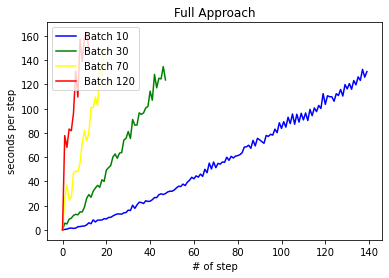

In [149]:
fig, ax = plt.subplots()
# ax.plot(range(len(step1)), ricalcola_lista(step1), label='Step 1', color='orange')
ax.plot(range(len(step10)), ricalcola_lista(step10), label='Batch 10', color='blue')
ax.plot(range(len(step30)), ricalcola_lista(step30), label='Batch 30', color='green')
ax.plot(range(len(step70)), ricalcola_lista(step70), label='Batch 70', color='yellow')
ax.plot(range(len(step120)), ricalcola_lista(step120), label='Batch 120', color='red')
ax.legend(loc='upper left')
plt.xlabel('# of step')
plt.ylabel('seconds per step')
plt.title('Full Approach')

Text(0.5, 1.0, 'Complete')

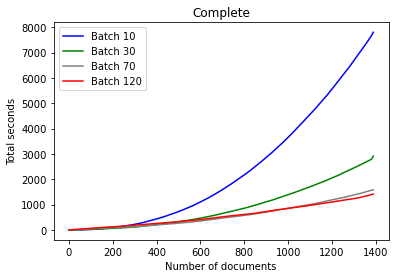

In [25]:
fig, ax = plt.subplots()
# ax.plot(list(range(1389)), step1, label='Step 1', color='orange')
ax.plot(list(range(0, 1388, 10)) + [1388], step10, label='Batch 10', color='blue')
ax.plot(list(range(0, 1388, 30)) + [1388], step30, label='Batch 30', color='green')
ax.plot(list(range(0, 1388, 70)) + [1388], step70, label='Batch 70', color='grey')
ax.plot(list(range(0, 1388, 120)) + [1388], step120, label='Batch 120', color='red')
ax.legend(loc='upper left')
plt.xlabel('Number of documents')
plt.ylabel('Total seconds')
plt.title('Complete')

# plt.savefig('./images/time.png')

plot of scores in times

In [10]:
path  = 'D:\Sgmon\Documents\Magistrale\TESI\Results\\time_evolving\\'
b3_120 ,ceaf_120 = get_scores(path + "step120/")
b3_70 ,ceaf_70 = get_scores(path + "step70/")
b3_30 ,ceaf_30 = get_scores(path + "step30/")
b3_10 ,ceaf_10 = get_scores(path + "step10/")
b3_1 ,ceaf_1 = get_scores(path + "step1/")


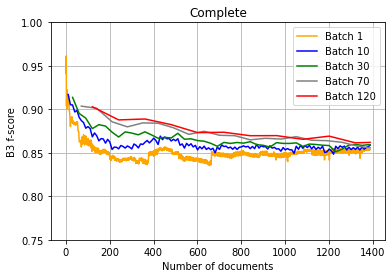

In [152]:
fig, ax = plt.subplots()
plt.ylim([0.75, 1])
plt.grid()
ax.plot(list(range(0, 1388)), b3_1, label='Batch 1', color='orange')
ax.plot(list(range(11, 1388, 10)) + [1388], b3_10, label='Batch 10', color='blue')
ax.plot(list(range(31, 1388, 30)) + [1388], b3_30, label='Batch 30', color='green')
ax.plot(list(range(71, 1388, 70)) + [1388], b3_70, label='Batch 70', color='grey')
ax.plot(list(range(121, 1388, 120)) + [1388], b3_120, label='Batch 120', color='red')
ax.legend(loc='upper right')
plt.xlabel('Number of documents')
plt.ylabel('B3 f-score')
plt.title('Complete')
plt.savefig('./images/full_approach_b3.png')

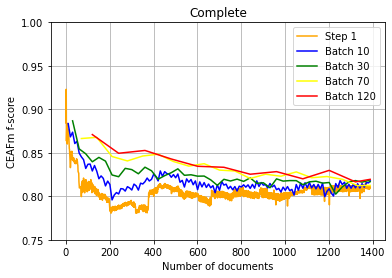

In [153]:
fig, ax = plt.subplots()
plt.ylim([0.75, 1])
plt.grid()
ax.plot(list(range(0, 1388)), ceaf_1, label='Step 1', color='orange')
ax.plot(list(range(11, 1388, 10)) + [1388], ceaf_10, label='Batch 10', color='blue')
ax.plot(list(range(31, 1388, 30)) + [1388], ceaf_30, label='Batch 30', color='green')
ax.plot(list(range(71, 1388, 70)) + [1388], ceaf_70, label='Batch 70', color='yellow')
ax.plot(list(range(121, 1388, 120)) + [1388], ceaf_120, label='Batch 120', color='red')
ax.legend(loc='upper right')
plt.xlabel('Number of documents')
plt.ylabel('CEAFm f-score')
plt.title('Complete')
plt.savefig('./images/full_approach_ceaf.png')


# base

In [5]:
path = 'D:\Sgmon\Documents\Magistrale\TESI\Results\without_mention_soglia\\'
# step_10_basic = [0,0.4254860021173954, 1.0296186350751668, 2.415590815944597, 3.907247507944703, 5.099389116978273, 6.571886156918481, 9.125277697108686, 11.835652448004112, 15.061320499982685, 18.20797237404622, 22.432185472920537, 28.153668699087575, 33.0799692729488, 41.18358126305975, 47.518368411110714, 55.26335236406885, 62.979700261959806, 70.89874388393946, 79.78474266291596, 88.46763461595401, 98.45416517392732, 108.39152771909721, 119.44217536994256, 130.59552329895087, 143.2394705649931, 155.4978349369485, 168.15563266701065, 181.51624798891135, 195.64698234712705, 211.60137275606394, 227.07741649309173, 246.98316540196538, 264.40594337903894, 284.6092797529418, 304.46264277095906, 326.3049260310363, 347.25604974408634, 370.24674929096363, 393.00647401297465, 416.0418259699363, 440.47318016109057, 467.0041529799346, 493.0721948319115, 521.6214261280838, 550.6580188139342, 579.5686605710071, 608.654130567098, 638.5889176889323, 669.4411977089476, 699.9583213280421, 731.3419937649742, 765.2963038040325, 799.6300982700195, 834.6547397340182, 870.5217422479764, 905.8548432940152, 942.684311192017, 981.8603098280728, 1022.2837669679429, 1063.0918791231234, 1105.8581726530101, 1148.348237099126, 1191.0459838490933, 1234.1159246929456, 1280.148997796001, 1326.6546815619804, 1378.7986005761195, 1426.7584170219488, 1475.9396038379055, 1526.550819346914, 1577.5227026289795, 1630.2054502810352, 1684.5759018370882, 1739.645411731908, 1795.6516868520994, 1853.1062901439145, 1910.635294873966, 1968.9074735350441, 2026.7586996569298, 2086.7069475159515, 2146.630315955961, 2208.1523423509207, 2271.052713312907, 2335.1830471449066, 2400.7814238159917, 2466.7323935029563, 2534.0188628640026, 2601.978118510917, 2671.598224437097, 2741.099757195916, 2811.233338274993, 2881.0533571890555, 2952.507522680098, 3026.5573175109457, 3102.9184235199355, 3179.304724206915, 3257.620414575096, 3335.6358705230523, 3416.70989780291, 3497.665610464057, 3579.6395033230074, 3661.6047876130324, 3745.577739099972, 3829.6784317840356, 3915.294280820992, 4001.8216322029475, 4088.9382157090586, 4175.707519604126, 4264.6400773481, 4352.689218660118, 4442.56791801611, 4532.49507515505, 4625.350849156966, 4717.074827682925, 4811.268974042032, 4907.266653697938, 5001.876570635941, 5099.809512417996, 5199.991131304065, 5301.281928993063, 5404.333436317975, 5507.230876350077, 5611.199290458113, 5716.392977358075, 5822.274926285958, 5933.5991823980585, 6042.161142816069, 6151.693683226127, 6266.082216494018, 6381.507194414036, 6495.555907071102, 6610.809487090912, 6728.1987581551075, 6846.201883191941, 6965.642236547079, 7086.289036087925, 7206.72706918302, 7328.557058005128, 7451.049940020079]
# step1_basic = [0, 0.03329783701337874, 0.04642923711799085, 0.06158980913460255, 0.09810975007712841, 0.12238548113964498, 0.16173661197535694, 0.21689175511710346, 0.2652114580851048, 0.340090709971264, 0.39572492404840887, 0.45919607602991164, 0.523000804008916, 0.5897978229913861, 0.6819227561354637, 0.8146176550071687, 0.9408258241601288, 1.06591945909895, 1.187565712025389, 1.3369338980410248, 1.5106149620842189, 1.6815735381096601, 1.979478695197031, 2.207061418099329, 2.4770076479762793, 2.7884606360457838, 3.0823239660821855, 3.3740942731965333, 3.698938379995525, 4.016581770032644, 4.503630686085671, 4.92135988897644, 5.414116457104683, 5.941514973063022, 6.469355236040428, 7.010470635024831, 7.555705494014546, 8.136427448131144, 8.77041257917881, 9.391081779031083, 10.180225169053301, 10.905427722027525, 12.262881166068837, 13.005050081992522, 13.735854667145759, 14.556159750092775, 15.38527692714706, 16.269602828193456, 17.19468726613559, 18.10504235699773, 19.095590408192948, 20.06445413408801, 21.081151223974302, 22.079421107191592, 23.108770827995613, 24.15007678209804, 25.22024406399578, 26.39768149005249, 27.529448657063767, 28.708286277018487, 29.92236977396533, 31.557356239063665, 33.16048431303352, 34.7906555570662, 37.050094372127205, 38.71913272514939, 40.37452558497898, 42.02677537314594, 43.72383138211444, 45.48417921317741, 47.285469816066325, 49.117574053118005, 50.91819454613142, 52.91061995504424, 54.959568466991186, 56.978325771167874, 59.08335614902899, 61.15944774309173, 63.25371452514082, 65.42745269509032, 68.20863259700127, 70.48586728912778, 72.76091155805625, 75.10730620916001, 77.54058643197641, 79.89023671601899, 82.37401426304132, 84.92565155704506, 87.38639700901695, 89.96412211610004, 92.59974385309033, 95.3112741461955, 98.03212496009655, 101.43995513115078, 104.21579113719054, 107.01619806000963, 109.90324950101785, 112.78090939717367, 115.70952795399353, 118.60887094400823, 121.52639755699784, 124.44314689515159, 127.480306499172, 130.44541268399917, 134.07526671118103, 137.05869302502833, 140.06364908115938, 143.10262311203405, 146.22873429208994, 149.35522926598787, 152.5483944020234, 155.72982907108963, 158.94110111915506, 162.1623237701133, 165.45946080610156, 169.28514305711724, 172.8134718821384, 176.3570841671899, 180.04794095107354, 184.63125326111913, 188.805150922155, 193.5027689479757, 198.1147945909761, 202.70487241703086, 207.4640129180625, 212.64539618208073, 217.32193728210405, 222.02492688409984, 226.7752630971372, 231.55022560898215, 236.3804511721246, 241.19997740513645, 246.02630129200406, 250.9192171341274, 256.3847470791079, 262.60564962611534, 268.37130275112577, 274.14373859902844, 279.88757822918706, 285.786260509165, 291.7110202210024, 297.6755624189973, 304.3914176521357, 310.7307924660854, 316.91819767002016, 323.1402265680954, 329.52344990405254, 335.7983992781956, 342.03068692819215, 348.90773396007717, 355.4213416320272, 362.00894658407196, 368.2945368241053, 374.6679640621878, 381.05751016619615, 387.49868863099255, 394.1366034729872, 401.3688135901466, 408.2101694350131, 415.1197892280761, 422.0767185490113, 429.1214068811387, 436.14249995118007, 443.1950953900814, 450.85480350698344, 457.9889635890722, 465.17038667201996, 472.33611104800366, 479.71733479201794, 487.2435890880879, 494.8564186170697, 502.76407820009626, 510.400736319134, 518.433956393972, 526.2030866371933, 534.1738140331581, 542.47853558301, 550.617864578031, 559.4904097141698, 567.6552376970649, 575.9377696011215, 584.1422660881653, 592.4042133921757, 600.5061283120885, 610.371720883064, 618.4954341761768, 626.8176508231554, 635.0522329660598, 643.5397022559773, 651.8903673950117, 660.2359232599847, 669.9989352810662, 678.8472906660754, 687.6285212570801, 696.2470460960176, 704.9026122691575, 713.558737489162, 723.0068262179848, 732.0288313261699, 740.8477650890127, 749.7069373361301, 758.5710009180475, 767.50317365909, 776.9181264501531, 785.8104072441347, 794.8088796671946, 804.0754945070948, 813.4249581170734, 822.6835808299948, 832.5422090361826, 842.3231562371366, 852.0108336519916, 861.6344320520293, 871.5510357781313, 881.1494965059683, 891.285379271023, 900.8953737420961, 910.6562631160486, 920.3362601210829, 930.207444980042, 940.0921352850273, 950.8184511549771, 960.8997344779782, 971.0068529371638, 981.0979328060057, 991.606247849064, 1001.7662187630776, 1013.0454882201739, 1023.4719117740169, 1034.1542064570822, 1044.786116334144, 1055.6792783020064, 1066.6602176390588, 1078.2410305719823, 1089.407988093095, 1100.6423558529932, 1111.6802258531097, 1122.9114802361, 1134.6911070470233, 1146.00257646502, 1157.361522924155, 1168.9478299871553, 1180.5369768231176, 1192.3021556341555, 1204.5572110000066, 1216.313870731974, 1228.0712278201245, 1239.891598090995, 1252.3430944089778, 1264.8975049341097, 1277.1189161101356, 1289.1619099301752, 1301.4920942210592, 1313.6378800501116, 1326.477187814191, 1338.7529171500355, 1351.4418539491016, 1363.8844498661347, 1376.0109713021666, 1388.7417162091006, 1401.1376182970125, 1413.5525660370477, 1426.0675811080728, 1438.5472640150692, 1451.2358270150144, 1464.336898497073, 1477.085844330024, 1489.849653690122, 1502.7824238319881, 1515.471935067093, 1528.8349211460445, 1541.6431853461545, 1554.9637366731185, 1568.3009463790804, 1581.8488328959793, 1596.0486628341023, 1609.642200732138, 1623.3618725070264, 1637.2208427509759, 1651.212694521062, 1665.7723097871058, 1679.6257363890763, 1693.5752079309896, 1708.064451236045, 1722.518826104002, 1737.4891452051234, 1751.9158449240495, 1766.4621626390144, 1780.9013497321866, 1795.3997688309755, 1810.544459091965, 1825.4829352099914, 1840.6505863280036, 1855.6591314449906, 1871.3260320930276, 1886.7751555570867, 1902.089818737004, 1917.4505106301513, 1932.8424964861479, 1948.9650471091736, 1964.3860039191786, 1979.9130073180422, 1995.473528864095, 2011.226968472125, 2027.4421483371407, 2043.0348665551282, 2058.607609888073, 2074.4626076521818, 2090.6766679401044, 2106.3302139530424, 2122.305913096061, 2138.3916227940936, 2154.436787392013, 2171.027214229107, 2187.2981563091744, 2203.6326148351654, 2219.863723500166, 2236.648983326042, 2253.06384809711, 2272.091878858162, 2290.199056660058, 2308.10029491107, 2326.8389879120514, 2345.111365228193, 2363.0626651470084, 2381.3398711930495, 2400.6065713670105, 2418.998932503164, 2437.418799240142, 2455.760439993115, 2474.167077914113, 2493.1503479629755, 2511.8476161120925, 2531.6771151670255, 2551.2477819661144, 2571.884735546075, 2591.684467307059, 2611.5828623001, 2631.628928774968, 2651.8726747410838, 2671.8396953260526, 2691.4927479820326, 2711.3558566330466, 2731.931872549001, 2752.308318102965, 2772.222752670059, 2792.510136868106, 2813.360608361196, 2833.9820856030565, 2854.654822941171, 2875.201883957023, 2897.96834756108, 2919.6309861140326, 2941.033442493994, 2962.5009713240433, 2984.398188612191, 3005.9410738230217, 3027.4525471650995, 3048.885101243155, 3070.7361689310055, 3092.1107128460426, 3113.30895840819, 3134.1146151341964, 3156.2406743341126, 3177.3605659520254, 3198.37106373813, 3219.559186805971, 3241.625929916976, 3263.0338380371686, 3284.5635605221614, 3305.8183952809777, 3327.666993023129, 3349.241219380172, 3370.964359189151, 3392.7273979170714, 3415.2944847000763, 3436.8621720189694, 3458.769203200005, 3480.5523081680294, 3503.4041917230934, 3525.4996861880645, 3548.1726027950644, 3570.8978194301017, 3594.062699839007, 3616.8915056090336, 3639.269129614113, 3662.6643803871702, 3685.233615481993, 3708.2450909169856, 3731.030935584102, 3754.14822065318, 3776.2343700530473, 3798.7478230411652, 3821.4235430480912, 3844.9974507251754, 3867.4699567509815, 3890.3522425850388, 3913.366909872042, 3936.903850703966, 3960.555138689, 3984.023029034026, 4008.283884528093, 4031.9811178031377, 4055.6889482231345, 4079.4942782360595, 4103.926876229001, 4127.475330423098, 4150.943297750084, 4174.98833104712, 4199.157401586184, 4222.651682455093, 4246.429233015049, 4271.284660573117, 4295.452796362108, 4319.852802272188, 4344.337836459046, 4369.6359207881615, 4394.719179174164, 4419.541353014065, 4445.5704702751245, 4471.181790841045, 4496.305086423177, 4521.946787724039, 4547.976618394023, 4573.011171082966, 4598.642593914177, 4624.250177106122, 4650.2368396080565, 4675.2313747901935, 4701.059110107133, 4727.876458795043, 4754.9003473401535, 4781.078217450064, 4807.533534916118, 4834.854699362069, 4861.7398044120055, 4889.573470923118, 4918.016940823058, 4945.561438160017, 4972.297186501091, 5000.658284471137, 5028.355890862178, 5056.231613620184, 5083.715689691016, 5111.755449122982, 5139.254951063078, 5166.837355733151, 5195.162118916167, 5222.8791926431, 5251.507875412004, 5279.589924036991, 5308.490187506191, 5336.183293357026, 5363.941748328973, 5392.38299784204, 5420.560466177994, 5449.233694166178, 5478.153281524079, 5507.436958051054, 5535.908796200063, 5564.6712787579745, 5594.0034142890945, 5622.629760722164, 5651.173255208181, 5680.299496922176, 5709.322872559074, 5738.4404931860045, 5767.203743951162, 5796.578367431182, 5825.715083998162, 5854.76475577103, 5884.437870734138, 5913.483132755151, 5942.741242246004, 5972.735124064144, 6001.994333002018, 6032.057874493999, 6062.4786159060895, 6091.972149897134, 6122.328873466002, 6152.221226732014, 6183.108527047094, 6213.087734033121, 6243.4698017151095, 6273.964292907156, 6303.801004396053, 6333.948756892001, 6364.73198691709, 6394.8235260590445, 6424.628142062109, 6455.539931469131, 6486.661260358989, 6516.9619278660975, 6547.159548587166, 6577.578904642025, 6608.685470200144, 6639.830516764196, 6671.506707943045, 6702.306850165129, 6732.716912612086, 6764.1850281481165, 6793.941598261008, 6823.965507240035, 6855.0893377061, 6885.7851650521625, 6916.231826456031, 6946.99295703508, 6978.08508601808, 7008.515668079024, 7038.891979970969, 7069.6135887240525, 7100.302499195095, 7131.005775270984, 7162.252584964037, 7193.005419482011, 7223.6657005331945, 7255.6838411330245, 7288.41390649206, 7320.1195969181135, 7352.797124636127, 7384.830929307966, 7416.851715089055, 7448.866502081044, 7481.476150479168, 7513.670052760048, 7546.036428090185, 7579.536257005995, 7612.561099970015, 7645.365522657055, 7678.661045324057, 7711.821777836187, 7745.109113288112, 7778.796613723971, 7812.629582025111, 7846.0297799601685, 7880.034762114054, 7913.486935394118, 7946.909934939118, 7981.267045628978, 8015.105526534142, 8049.051077028038, 8084.021418309072, 8118.919190770015, 8153.181124157971, 8187.485336611047, 8221.58518054313, 8255.785890580155, 8290.242262741085, 8324.224146461114, 8358.4892677241, 8393.054838828975, 8427.195789488032, 8461.330301013077, 8496.193360120058, 8530.769812733168, 8565.195573172998, 8600.069818932097, 8634.505120214075, 8669.033441943116, 8703.902751190122, 8739.033167835092, 8773.70438781497, 8808.945055637043, 8844.026029129978, 8879.31731535215, 8915.02144388808, 8950.282658545999, 8985.650555312168, 9021.142087887041, 9057.10856558499, 9093.024730834179, 9129.374629599974, 9165.035547137028, 9201.133268724196, 9238.300922619179, 9274.946332779014, 9312.349784306018, 9349.097841023002, 9386.18096545618, 9423.45161038707, 9460.448118874105, 9498.116921187146, 9537.179064176977, 9574.875659363111, 9613.130518088117, 9651.64737523999, 9689.991646556184, 9728.755982401082, 9768.03695645812, 9807.27772718016, 9847.114671244984, 9888.370421173982, 9928.992409617174, 9969.366573019186, 10011.563395923004, 10052.17610101914, 10092.41233975906, 10134.45388802397, 10175.211433422053, 10217.086781077087, 10258.391116954153, 10300.681464030175, 10342.772114895051, 10386.140436035115, 10429.056151993107, 10472.398050884018, 10514.101323947078, 10555.587691944093, 10597.687124774093, 10638.990360985044, 10680.840825773077, 10722.260179226054, 10764.19308792497, 10806.673843729077, 10848.439540719148, 10890.395050342195, 10932.916513027158, 10973.413279636065, 11014.550360009074, 11054.82454170403, 11095.67368470109, 11137.064929190092, 11178.302726880182, 11219.13938670815, 11261.022488172166, 11303.325355228968, 11345.780151450075, 11388.90783772897, 11431.045098816976, 11474.28487252607, 11516.762033389183, 11559.370848002145, 11602.73335812497, 11645.56981698703, 11688.37511454802, 11731.971235577017, 11774.792529770173, 11817.588102856185, 11861.107295249123, 11903.042386027053, 11946.418229781091, 11989.852191807004, 12033.822378456127, 12077.870032967068, 12121.788428219035, 12165.845369177172, 12211.637959036976, 12258.153773228172, 12303.527679244988, 12348.01750803506, 12392.598965088138, 12437.642504959134, 12482.175315016182, 12526.902497261064, 12572.148245653138, 12617.10169249517, 12662.461008626968, 12707.010031011188, 12751.84213382611, 12797.03708955017, 12841.658620037138, 12886.214037052123, 12931.392615274992, 12976.143314106157, 13023.890079305042, 13069.897955785971, 13116.150120252976, 13163.230780470185, 13209.973304477055, 13257.39021718409, 13304.173316864064, 13351.299338537967, 13399.051764165983, 13446.193832898047, 13494.332237391034, 13541.941162116127, 13589.649125430966, 13637.529226019979, 13685.081015521195, 13733.18735976005, 13780.66327911918, 13828.334916978143, 13876.644697345095, 13924.52178547415, 13972.625029137125, 14020.28858751501, 14068.184874479193, 14116.534013324184, 14164.486863947008, 14212.934115900192, 14261.050756238168, 14309.729194184998, 14358.362789854174, 14407.363819460152, 14456.362483025994, 14505.75766183203, 14554.23918766412, 14603.80685204314, 14653.32248087111, 14702.91388991219, 14751.953549279133, 14801.286214604974, 14851.245979505125, 14900.20177157619, 14950.469644721132, 14999.797772502992, 15049.188236202113, 15098.814645203995, 15150.580952157965, 15200.999052297091, 15251.507571983151, 15302.425402896013, 15354.128196361009, 15405.299985976191, 15457.087781897048, 15508.048073244048, 15559.132995837135, 15610.60686515714, 15661.909178463975, 15713.555435753195, 15764.838441509055, 15816.190384557005, 15868.156262892066, 15919.633841454051, 15972.314058337128, 16024.490489270072, 16077.700121185044, 16130.371361367172, 16183.125672783004, 16236.398570120102, 16289.107725544134, 16342.716629689094, 16395.43300103699, 16448.54659559205, 16501.52370321704, 16554.287814888172, 16607.799173532054, 16660.878244969994, 16714.96762537211, 16768.026353999972, 16821.228674795013, 16875.71042333613, 16929.45369221503, 16983.995489879046, 17038.22343523102, 17092.821537874173, 17147.229619491147, 17201.581424172968, 17256.886144245043, 17311.160904286196, 17366.13443665905, 17420.548280769028, 17475.866406202083, 17530.207155080047, 17584.647831574082, 17640.077435525134, 17695.092455137055, 17750.454998819157, 17805.687715762993, 17861.272589919157, 17916.08160077408, 17971.09216024517, 18027.301560053136, 18082.648440124, 18138.529637338128, 18194.047647078987, 18249.577748422977, 18305.612487076083, 18361.343234909, 18417.335801480105, 18473.106059449026, 18529.499365312047, 18585.33799455408, 18642.59240005398, 18698.31511022919, 18754.564063971164, 18810.91159206303, 18867.76085185702, 18924.571986912983, 18981.240176615072, 19038.047427037032, 19094.382718672045, 19150.895072794985, 19207.951572809136, 19265.02889060299, 19321.914120268077, 19378.410697563086, 19435.541885217186, 19492.484248321038, 19549.126745478017, 19606.483272972982, 19664.07431947603, 19721.651070922147, 19778.71469084802, 19836.559450485976, 19894.011632079026, 19952.085816469975, 20009.296075423015, 20066.8524873571, 20125.559269749094, 20183.104362959042, 20241.490727365017, 20299.557243995136, 20358.09212434804, 20415.673568583094, 20474.0491079411, 20533.20829869318, 20592.087505778065, 20651.379444017075, 20709.659594533034, 20769.039657031186, 20828.012150797993, 20887.86097049201, 20946.455381789012, 21005.699581691064, 21065.195080157137, 21124.00118258316, 21183.558011716, 21242.838939591078, 21303.273958447156, 21362.90379549912, 21423.373058089986, 21483.558467908064, 21543.835090961074, 21604.889645239105, 21665.563441046048, 21726.376537831966, 21786.62683289405, 21847.333231609082, 21908.145991974045, 21969.614614595193, 22030.006478768075, 22090.670220144093, 22151.31079524313, 22211.997633292107, 22273.030729130143, 22334.027657079045, 22396.409397220006, 22457.900549966143, 22519.757154368097, 22581.348251966992, 22643.231901752064, 22705.190241727047, 22767.262246213155, 22830.121366823092, 22892.558433284983, 22956.07473580609, 23018.052453272976, 23081.682434529997, 23144.03723125113, 23207.46523450315, 23270.172146036057, 23333.633361688117, 23396.50660882797, 23460.639606144978, 23523.47182200197, 23586.740114170127, 23650.323475952027, 23713.383540204028, 23777.61764462106, 23841.196901135147, 23905.052618809044, 23969.502059985185, 24034.38827332412, 24099.03329296899, 24164.137754779076, 24228.928579651983, 24294.27032232401, 24359.44015813619, 24424.707988266135, 24490.243574418128, 24555.567673104117, 24621.232032469008, 24687.591044147033, 24753.897727377014, 24819.762432724005, 24886.00684799906, 24951.76314433501, 25018.175320546143, 25084.326433071168, 25151.342000810197, 25217.722897658125, 25285.765194141073, 25351.917389444076, 25418.856113472022, 25486.57001265604, 25553.176377722062, 25619.48644220899, 25685.344766627997, 25752.12778150011, 25818.545067855157, 25885.936430233065, 25952.555568451993, 26020.24462617119, 26086.993207741063, 26153.77389892307, 26220.763489158126, 26288.47277917806, 26355.621046062093, 26423.527744243154, 26491.3475056421, 26559.415183588164, 26627.111910328036, 26694.501439769054, 26762.599483333994, 26829.94935264415, 26897.759965235135, 26965.39549243613, 27033.499409078155, 27101.514255834976, 27169.700649552047, 27237.630303813145, 27306.550911323167, 27374.124523042003, 27442.56934287399, 27510.10355638899, 27577.876451531192, 27646.36484938115, 27714.07042341819, 27782.460228207987, 27850.4121256331, 27919.422280088067, 27987.930612781085, 28056.3327016721, 28125.349867104087, 28194.310124531155, 28263.158248614054, 28331.88008689019, 28401.228398635983, 28470.537609052146, 28539.56266373815, 28608.862396014156, 28678.456422253046, 28749.409078649012, 28819.194746474037, 28890.892124385107, 28960.742763802176, 29031.679681234993, 29103.25244108797, 29174.99897039216, 29246.553276926978, 29319.562936953967, 29392.162993338192, 29465.014598013135, 29537.05253169802, 29610.76718643913, 29682.872317085974, 29757.131791737163, 29829.32065202901, 29901.635082624154, 29974.86841050908, 30048.288650213974, 30122.357781299157, 30194.99297929299, 30268.03572653397, 30341.20415483415, 30415.569593867054, 30488.92331356113, 30563.956433960004, 30638.021384911146, 30712.691611709073, 30787.144017022103, 30861.940834740177, 30936.61208267114, 31011.04489138699, 31085.522470387165, 31161.632372991182, 31236.661749917082, 31312.616352705983, 31388.081207219046, 31464.38673214917, 31540.38867880497, 31616.449138554977, 31692.210079584038, 31769.073639243143, 31845.10262377397, 31921.542970873183, 31997.857718540123, 32074.441787682008, 32151.11653252598, 32227.808155968087, 32304.248251124052, 32381.30282020406, 32458.808843687177, 32534.838420432992, 32611.93949744897, 32689.353195031174, 32767.056669978192, 32843.77399167814, 32922.53702053102, 32999.95535946917, 33078.18637264497, 33155.479875456076, 33233.736696818145, 33310.86403471511, 33389.81571295904, 33467.482080935035, 33545.80927664507, 33623.24143014103, 33702.50996915414, 33780.62241815217, 33858.462006872054, 33936.44731254899, 34014.401413564105, 34092.82961148699, 34171.583547997056, 34249.80769444513, 34328.717226656154, 34406.99593659607, 34485.44704456115, 34563.27672876418, 34641.75449614599, 34720.31569392118, 34799.134247277165, 34877.73073730315, 34957.10942646908, 35035.29231346701, 35114.93496845616, 35193.87882451713, 35273.985573817976, 35354.12845626101, 35432.768594886176, 35512.748587104026, 35592.078471428016, 35672.289357066154, 35751.84677898907, 35832.52637474099, 35912.39950132207, 35993.8750360331, 36073.829685464036, 36154.657484918134, 36235.91103355517, 36317.06127217016, 36397.53129238519, 36478.6251779811, 36559.65490761516, 36641.238236106, 36721.88304744405, 36803.00021008402, 36884.20279954118, 36966.00325708813, 37047.484145405004, 37129.33824471105, 37212.241692596115, 37293.97699310514, 37376.41442328901, 37457.829605997074, 37539.91064614104, 37623.564270723145, 37707.27822732506, 37790.15820867615, 37872.8292251532, 37955.334902648116, 38038.10308812419, 38120.03245784715, 38203.603255917085, 38286.46906436398, 38370.82499743509, 38453.286817237036, 38536.46941807214, 38619.15872826916, 38702.626330189174, 38786.07421537116, 38869.23902182304, 38953.066063808044, 39037.34270746913, 39122.21396399103, 39206.25647273101, 39291.00203991309, 39374.51168777514, 39459.5414768341, 39544.2712784491, 39628.79839438107, 39712.585870944196, 39797.445286398055, 39881.569924631156, 39965.94246156211, 40050.66773316404, 40135.44387003314, 40220.220104167005, 40305.041418580106, 40390.55910135899, 40475.35292234318, 40561.221798977116, 40645.787229672074, 40731.29965325119, 40816.273618669016, 40902.38772621611, 40988.74600154604, 41074.53840310313, 41160.058087941026, 41245.59244370507, 41331.82160448609, 41417.497920612106, 41503.07753130398, 41589.25826376211, 41675.44192268909, 41760.75913763908, 41847.16431204113, 41932.80836909404, 42019.14062114805, 42106.09903715318, 42192.34627606301, 42278.27713886718, 42364.855628611986, 42450.79008648009, 42536.88323204708, 42624.11381080304, 42710.47452758206, 42799.09527017013, 42886.28289702209, 42973.04137488897, 43059.179652396124, 43145.72118877713, 43231.82519731112, 43318.94362332299, 43405.40454661101, 43492.25033627101, 43579.47245349316, 43666.13998620212, 43753.808912405046, 43840.26809921814, 43927.78217674699, 44014.721149356104, 44102.26101196208, 44189.84797585197, 44277.56619260018, 44365.785358359106, 44454.90541908704, 44544.14297922817, 44633.17723327712, 44723.31564115803, 44811.856835640036, 44900.81527312612, 44989.99508748902, 45079.45431440207, 45169.01576865604, 45259.03952362714, 45348.613568410045, 45437.617872120114, 45527.906896683155, 45617.67398227402, 45708.23888194701, 45798.74658405618, 45889.031257214025, 45978.83967604698, 46070.154497597134, 46160.48059243406, 46251.270030792104, 46341.995130789, 46432.175288558006, 46522.87558425707, 46613.60659782216, 46705.70688617509, 46796.90956680011, 46888.73645295715, 46980.26345493412, 47070.29212571215, 47162.30381790409, 47252.51368097006, 47344.47165063908, 47435.84681672719, 47527.39434089302, 47619.30898443214, 47711.13952158601, 47803.87394101103, 47895.61551750614, 47988.034499772126, 48079.928646589164, 48172.31555538508, 48264.72961661802, 48357.28098391206, 48450.32309090812, 48543.14690442197, 48636.51874498697, 48728.305792531, 48822.27716985904, 48915.35081873415, 49008.72586582112, 49102.60529131116, 49196.740775461076, 49291.051905296976, 49385.191697306, 49478.96036315011, 49572.41622226313, 49666.90109208808, 49760.149408676196, 49855.81622614013, 49951.21179399802, 50047.13616613601, 50144.02144083707, 50240.312360750046, 50338.855272188084, 50436.49550170801, 50534.715099703055, 50632.84576357505, 50731.20413428219, 50829.58823623904, 50927.08862866508, 51025.29950456717, 51123.48789373902, 51221.885398678016, 51322.288774171146, 51421.529688928975, 51520.48226996418, 51619.21452978416, 51719.20077110012, 51819.195675347, 51918.872562780976, 52018.41431496618, 52117.29819841217, 52216.751758432016, 52315.79340718198, 52415.34543825197, 52514.6410956271, 52614.68786132615, 52714.65647360217, 52814.19649901311, 52914.102287778165, 53013.6239508891, 53112.837279101135, 53213.10337087419, 53312.32602815819, 53412.27177362214, 53512.64538715617, 53612.86153625301, 53712.80376527202, 53813.11145841703, 53914.74456902407, 54015.088344794, 54116.57069565612, 54217.80020947615, 54318.99125169404, 54421.274667696096, 54522.28284904314, 54624.129543172196, 54725.81008611107, 54827.38771919208, 54928.825495615136, 55030.6670480771, 55133.32161418209, 55235.33995179413, 55338.23975768313, 55439.44853519602, 55541.59061905113, 55645.02813462517, 55747.15649537998, 55849.94168332103, 55952.94619229203, 56055.85703208903, 56157.921024317155, 56261.27120552817, 56363.76835093298, 56467.31132772798, 56570.83615130698, 56674.05015457817, 56777.986119962065, 56882.755619545, 56986.59317122307, 57092.04182744608, 57197.047609776026, 57302.174461622024, 57406.95403074613, 57510.808179221116, 57616.302080942085, 57720.994617471006, 57826.885094475, 57932.736276285024, 58037.85014409013, 58144.128616154194, 58249.74634665297, 58355.83411755413, 58462.34259915701, 58567.31476274016, 58673.52149016806, 58779.185211951146, 58884.741449373076, 58990.776451346, 59096.87616022001, 59203.813383492175, 59310.32331250515, 59417.724213505164, 59526.115861972095, 59632.59237612109, 59741.36548780301, 59849.002543012146, 59957.242209671065, 60065.79574660398, 60173.24572156905, 60281.75476007513, 60390.44719780912, 60499.75486572902, 60609.00488474616, 60717.641883853124, 60827.27780368109, 60937.16232828912, 61047.206270856084, 61157.373263204005, 61267.69187071407, 61378.00928601506, 61487.79913907801, 61598.86512877117, 61709.81151527702, 61819.632037019124, 61929.76485028607, 62040.62251558108, 62150.96816013614, 62261.373809219105, 62372.26087279897, 62484.14709476498, 62596.08624223014, 62706.20126071805, 62818.39271915401, 62928.79796481412, 63039.39781550411, 63150.602407277096, 63261.94593967707, 63373.99820184009, 63485.90598598705, 63597.517595967045, 63709.128349530976, 63820.50608750316, 63932.39408387616, 64045.291608849075, 64157.22384665604, 64270.08327718009, 64382.31680042716, 64495.592664683005, 64609.62003591098, 64723.37855295604, 64839.55386960413, 64953.41569346003, 65068.13831919106, 65181.934315839084, 65295.72161812801, 65409.84473855514, 65524.056472313125, 65637.48314126208, 65752.34611754003, 65866.86488838005, 65982.2118804031, 66097.87065340206, 66212.53803548915, 66327.91524384404, 66443.06895191106, 66557.96347078797, 66673.0830186021, 66787.00354744913, 66902.33623604313, 67017.50758785103, 67132.46016929811, 67249.139690198, 67365.43929980905, 67480.847759197, 67597.0024973522, 67712.33753757505, 67827.92227863497, 67944.67452817014, 68061.21197209717, 68178.33761368599, 68296.56390612503, 68412.32379910606, 68529.688532667, 68646.34193788003, 68762.96209815703, 68880.25606288109, 68996.25216422207, 69113.60844055004, 69230.91037769103, 69347.90813102596, 69464.66956282617, 69582.47699714499, 69699.89281463297, 69817.30023828917, 69934.45189291216, 70051.36203193711, 70170.30654025008, 70287.77886242908, 70404.88746012002, 70522.12262376002, 70640.80590517703, 70758.89652983099, 70877.24756774912, 70996.38775166217, 71114.11007012217, 71233.60676392796, 71356.60316791502, 71479.36389079317, 71601.1185789681]
b3_1_base ,ceaf_1_base = get_scores(path + 'step1')
b3_10_base ,ceaf_10_base = get_scores(path + 'step10')
b3_30_base ,ceaf_30_base = get_scores(path + 'step30')
b3_70_base ,ceaf_70_base = get_scores(path + 'step70')
b3_120_base ,ceaf_120_base = get_scores(path + 'step120')


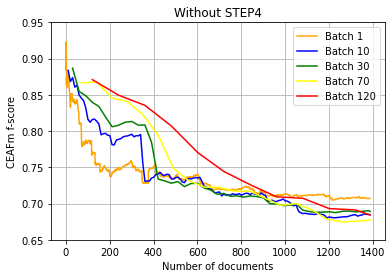

In [155]:
fig, ax = plt.subplots()
plt.ylim([0.65, 0.95])
plt.grid()
# ax.plot(list(range(11, 1388, 10)) + [1388], ceaf_10, label='Step 10', color='blue')
ax.plot(list(range(0, 1388, 1)), ceaf_1_base, label='Batch 1', color='orange')
ax.plot(list(range(11, 1388, 10)) + [1388], ceaf_10_base, label='Batch 10', color='blue')
ax.plot(list(range(31, 1388, 30)) + [1388], ceaf_30_base, label='Batch 30', color='green')
ax.plot(list(range(71, 1388, 70)) + [1388], ceaf_70_base, label='Batch 70', color='yellow')
ax.plot(list(range(121, 1388, 120)) + [1388], ceaf_120_base, label='Batch 120', color='red')
ax.legend(loc='upper right')
plt.xlabel('Number of documents')
plt.ylabel('CEAFm f-score')
plt.title('Without STEP4')
plt.savefig('./images/partial_approach_ceaf.png')

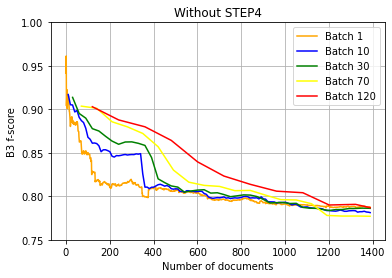

In [156]:
fig, ax = plt.subplots()
plt.ylim([0.75, 1])
plt.grid()
# ax.plot(list(range(11, 1388, 10)) + [1388], ceaf_10, label='Step 10', color='blue')
ax.plot(list(range(0, 1388, 1)), b3_1_base, label='Batch 1', color='orange')
ax.plot(list(range(11, 1388, 10)) + [1388], b3_10_base, label='Batch 10', color='blue')
ax.plot(list(range(31, 1388, 30)) + [1388], b3_30_base, label='Batch 30', color='green')
ax.plot(list(range(71, 1388, 70)) + [1388], b3_70_base, label='Batch 70', color='yellow')
ax.plot(list(range(121, 1388, 120)) + [1388], b3_120_base, label='Batch 120', color='red')
ax.legend(loc='upper right')
plt.xlabel('Number of documents')
plt.ylabel('B3 f-score')
plt.title('Without STEP4')
plt.savefig('./images/partial_approach_b3.png')

In [7]:
path  = 'D:\Sgmon\Documents\Magistrale\TESI\Results\\Baseline\\'
b3_120_baseline ,ceaf_120_baseline = get_scores(path + "step120/")
b3_70_baseline ,ceaf_70_baseline = get_scores(path + "step70/")
b3_30_baseline ,ceaf_30_baseline = get_scores(path + "step30/")
b3_10_baseline ,ceaf_10_baseline = get_scores(path + "step10/")

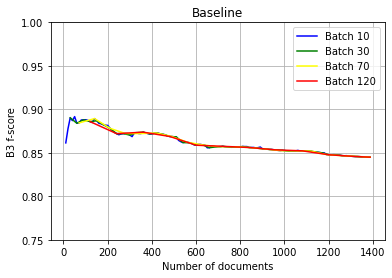

In [158]:
fig, ax = plt.subplots()
plt.ylim([0.75, 1])
plt.grid()
ax.plot(list(range(11, 1388, 10)) + [1388], b3_10_baseline, label='Batch 10', color='blue')
ax.plot(list(range(31, 1388, 30)) + [1388], b3_30_baseline, label='Batch 30', color='green')
ax.plot(list(range(71, 1388, 70)) + [1388], b3_70_baseline, label='Batch 70', color='yellow')
ax.plot(list(range(121, 1388, 120)) + [1388], b3_120_baseline, label='Batch 120', color='red')
ax.legend(loc='upper right')
plt.xlabel('Number of documents')
plt.ylabel('B3 f-score')
plt.title('Baseline')
plt.savefig('./images/baseline_approach_b3.png')

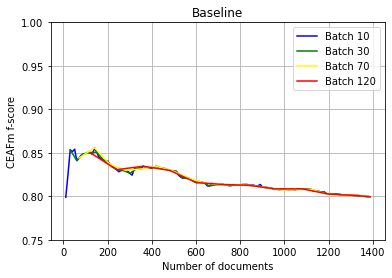

In [159]:
fig, ax = plt.subplots()
plt.ylim([0.75, 1])
plt.grid()
ax.plot(list(range(11, 1388, 10)) + [1388], ceaf_10_baseline, label='Batch 10', color='blue')
ax.plot(list(range(31, 1388, 30)) + [1388], ceaf_30_baseline, label='Batch 30', color='green')
ax.plot(list(range(71, 1388, 70)) + [1388], ceaf_70_baseline, label='Batch 70', color='yellow')
ax.plot(list(range(121, 1388, 120)) + [1388], ceaf_120_baseline, label='Batch 120', color='red')
ax.legend(loc='upper right')
plt.xlabel('Number of documents')
plt.ylabel('CEAFm f-score')
plt.title('Baseline')
plt.savefig('./images/baseline_approach_ceaf.png')

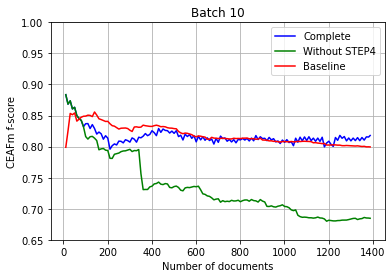

In [160]:
fig, ax = plt.subplots()
plt.ylim([0.65, 1])
plt.grid()
ax.plot(list(range(11, 1388, 10)) + [1388], ceaf_10, label='Complete', color='blue')
ax.plot(list(range(11, 1388, 10)) + [1388], ceaf_10_base, label='Without STEP4', color='green')
ax.plot(list(range(11, 1388, 10)) + [1388], ceaf_10_baseline, label='Baseline', color='red')

ax.legend(loc='upper right')
plt.xlabel('Number of documents')
plt.ylabel('CEAFm f-score')
plt.title('Batch 10')
plt.savefig('./images/step10_ceaf.png')

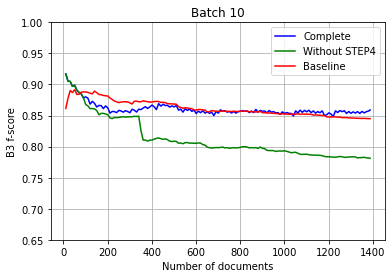

In [11]:
fig, ax = plt.subplots()
plt.ylim([0.65, 1])
plt.grid()
ax.plot(list(range(11, 1388, 10)) + [1388], b3_10, label='Complete', color='blue')
ax.plot(list(range(11, 1388, 10)) + [1388], b3_10_base, label='Without STEP4', color='green')
ax.plot(list(range(11, 1388, 10)) + [1388], b3_10_baseline, label='Baseline', color='red')
ax.legend(loc='upper right')
plt.xlabel('Number of documents')
plt.ylabel('B3 f-score')
plt.title('Batch 10')
plt.savefig('./images/step10_b3.png')

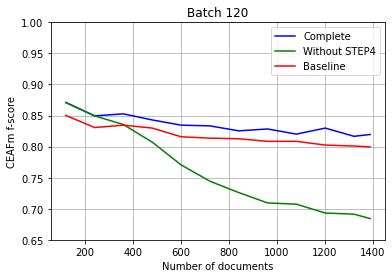

In [162]:
fig, ax = plt.subplots()
plt.ylim([0.65, 1])
plt.grid()
ax.plot(list(range(121, 1388, 120)) + [1388], ceaf_120, label='Complete', color='blue')
ax.plot(list(range(121, 1388, 120)) + [1388], ceaf_120_base, label='Without STEP4', color='green')
ax.plot(list(range(121, 1388, 120)) + [1388], ceaf_120_baseline, label='Baseline', color='red')
ax.legend(loc='upper right')
plt.xlabel('Number of documents')
plt.ylabel('CEAFm f-score')
plt.title('Batch 120')
plt.savefig('./images/step120_ceaf.png')

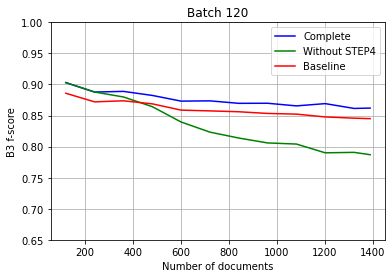

In [163]:
fig, ax = plt.subplots()
plt.ylim([0.65, 1])
plt.grid()
ax.plot(list(range(121, 1388, 120)) + [1388], b3_120, label='Complete', color='blue')
ax.plot(list(range(121, 1388, 120)) + [1388], b3_120_base, label='Without STEP4', color='green')
ax.plot(list(range(121, 1388, 120)) + [1388], b3_120_baseline, label='Baseline', color='red')
ax.legend(loc='upper right')
plt.xlabel('Number of documents')
plt.ylabel('B3 f-score')
plt.title('Batch 120')
plt.savefig('./images/step120_b3.png')

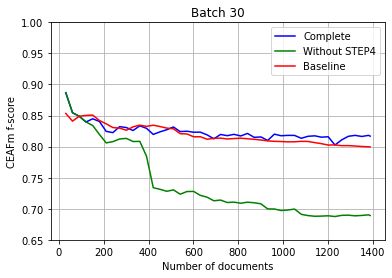

In [164]:
fig, ax = plt.subplots()
plt.ylim([0.65, 1])
plt.grid()
ax.plot(list(range(31, 1388, 30)) + [1388], ceaf_30, label='Complete', color='blue')
ax.plot(list(range(31, 1388, 30)) + [1388], ceaf_30_base, label='Without STEP4', color='green')
ax.plot(list(range(31, 1388, 30)) + [1388], ceaf_30_baseline, label='Baseline', color='red')
ax.legend(loc='upper right')
plt.xlabel('Number of documents')
plt.ylabel('CEAFm f-score')
plt.title('Batch 30')
plt.savefig('./images/step30_ceaf.png')

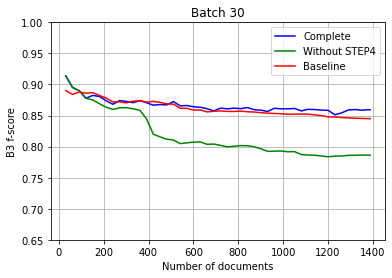

In [165]:
fig, ax = plt.subplots()
plt.ylim([0.65, 1])
plt.grid()
ax.plot(list(range(31, 1388, 30)) + [1388], b3_30, label='Complete', color='blue')
ax.plot(list(range(31, 1388, 30)) + [1388], b3_30_base, label='Without STEP4', color='green')
ax.plot(list(range(31, 1388, 30)) + [1388], b3_30_baseline, label='Baseline', color='red')
ax.legend(loc='upper right')
plt.xlabel('Number of documents')
plt.ylabel('B3 f-score')
plt.title('Batch 30')
plt.savefig('./images/step30_b3.png')

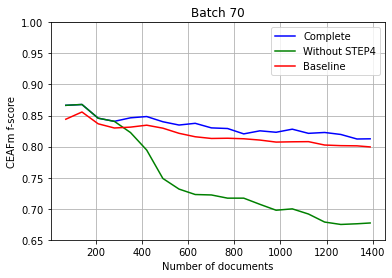

In [166]:
fig, ax = plt.subplots()
plt.ylim([0.65, 1])
plt.grid()
ax.plot(list(range(71, 1388, 70)) + [1388], ceaf_70, label='Complete', color='blue')
ax.plot(list(range(71, 1388, 70)) + [1388], ceaf_70_base, label='Without STEP4', color='green')
ax.plot(list(range(71, 1388, 70)) + [1388], ceaf_70_baseline, label='Baseline', color='red')
ax.legend(loc='upper right')
plt.xlabel('Number of documents')
plt.ylabel('CEAFm f-score')
plt.title('Batch 70')
plt.savefig('./images/step70_ceaf.png')

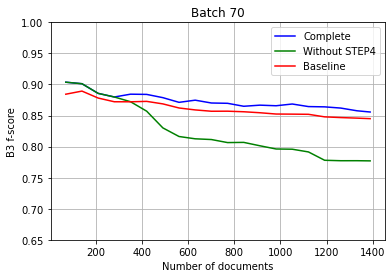

In [167]:
fig, ax = plt.subplots()
plt.ylim([0.65, 1])
plt.grid()
ax.plot(list(range(71, 1388, 70)) + [1388], b3_70, label='Complete', color='blue')
ax.plot(list(range(71, 1388, 70)) + [1388], b3_70_base, label='Without STEP4', color='green')
ax.plot(list(range(71, 1388, 70)) + [1388], b3_70_baseline, label='Baseline', color='red')
ax.legend(loc='upper right')
plt.xlabel('Number of documents')
plt.ylabel('B3 f-score')
plt.title('Batch 70')
plt.savefig('./images/step70_b3.png')

In [168]:
mentions = list(ents_data.mentions)
ents_dict = {ent:[] for ent in entities}
for i, ent in enumerate(entities):
    ents_dict[ent].append(mentions[i])

In [169]:
for ent in ents_dict:
    ents_dict[ent]= len(set([x.lower() for x in ents_dict[ent]]))

In [170]:
max(ents_dict.values())


9

In [171]:
import numpy as np
import pandas as pd
org = pd.read_csv("./aida-yago2-dataset/query (1).csv", header=0)
org['nick'] = org['nick'].str.lower()
org = org.drop_duplicates()
ban_field = set(org['s'])

In [172]:
loc = pd.read_csv("./aida-yago2-dataset/query (2).csv")
loc['nick'] = loc['nick'].str.lower()
loc = loc[~loc.nick.isin(ban_field)]
loc = loc.drop_duplicates()
ban_field = ban_field.union(set(loc['s']))

In [173]:
per = pd.read_csv("./aida-yago2-dataset/query (3).csv")
per['nick'] = per['nick'].str.lower()
per = per[~per.nick.isin(ban_field)]
per = per.drop_duplicates()

In [174]:
mix = pd.concat([org,per,loc], ignore_index=True)

In [175]:
np.quantile(list(mix.groupby('s').count()['nick']),0.8)

9.0

In [176]:
mix.shape

(695873, 2)

In [177]:
elements = mix.groupby('s').count()['nick']



In [178]:
from scipy.stats import iqr
val_iqr = iqr(elements)

In [179]:
val_iqr*1.5 + np.quantile(list(mix.groupby('s').count()['nick']),0.75)


16.0

In [180]:
np.quantile(list(mix.groupby('s').count()['nick']), 0.75)

7.0

In [181]:
np.quantile(list(mix.groupby('s').count()['nick']), 0.25)


1.0